In [1]:
import os

# Check if we're in the root directory of rl-llm repo
if not os.path.basename(os.getcwd()) == 'rl-llm':
    # If we're in a subdirectory of rl-llm, find the root and cd to it
    current_path = os.getcwd()
    while os.path.basename(current_path) != 'rl-llm' and os.path.dirname(current_path) != current_path:
        current_path = os.path.dirname(current_path)
    
    if os.path.basename(current_path) == 'rl-llm':
        os.chdir(current_path)
        print(f"Changed directory to: {current_path}")
    else:
        print("Not in rl-llm repository structure")
else:
    print("Already in rl-llm root directory")

print(f"Current directory: {os.getcwd()}")

Changed directory to: /workspace/rl-llm
Current directory: /workspace/rl-llm


In [2]:
# Import necessary libraries
import os
import torch
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import logging
from src import EnvManager, sample_episodes
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig
from typing import List, Dict, Tuple

# Suppress spammy logs from transformers, 
# e.g. "Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation."
logging.getLogger("transformers").setLevel(logging.ERROR)

/workspace/rl-llm/.venv/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-GoTo-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/workspace/rl-llm/.venv/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-Open-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/workspace/rl-llm/.venv/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-Pickup-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/workspace/rl-llm/.venv/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment BabyAI-PutNext-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [3]:
def load_model(model_id, revision=None):
    """
    Load a model with both PEFT adapters and value head
    
    Args:
        model_id: Path to model or HF hub model ID
        device: Device to load the model to
        revision: Specific model revision/commit hash to load
    
    Returns:
        model: The loaded model with adapters and value head
        tokenizer: The associated tokenizer
    """
    
    tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left', revision=revision)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    peft_config = PeftConfig.from_pretrained(model_id, revision=revision)
    base_model_id = peft_config.base_model_name_or_path
    
    logging.info(f"Loading base model: {base_model_id}")
    logging.info(f"Loading with PEFT adapters from: {model_id}")
    if revision:
        logging.info(f"Using revision: {revision}")
    
    base_model = AutoModelForCausalLM.from_pretrained(base_model_id)
    model = PeftModel.from_pretrained(base_model, model_id, revision=revision)
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
    return model, tokenizer


def load_base_model(model_id):
    """
    Load a base model with value head
    
    Args:
        model_id: Path to model or HF hub model ID
    
    Returns:
        model: The loaded model with value head
        tokenizer: The associated tokenizer
    """
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left')
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    logging.info(f"Loading base model with value head from: {model_id}")
    
    model = AutoModelForCausalLM.from_pretrained(model_id)
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
    return model, tokenizer


In [4]:
# Specify models to be evaluated
model_configs = {
    "Baseline": {
        "load_fn": load_base_model,
        "model_id": "meta-llama/Llama-3.2-3B-Instruct", 
        "reasoning_flag": None
    },
    "Trial2r": {
        "load_fn": load_model,
        "model_id": "CatkinChen/final_runs-Reasoning_trial_2_dist_0",
        "revision": '15e9cb622708f56f7da77421420bf42fe426b9c7',   # Optionally set a revision if needed
        "reasoning_flag": True
    },
    "Trial2": {
        "load_fn": load_model,
        "model_id": "CatkinChen/final_runs-No_Reasoning__trial_2",
        "revision": 'fc13267d7ef0c56e840b76728539f75352796456',   # Optionally set a revision if needed
        "reasoning_flag": False
    },
    "Trial1": {
        "load_fn": load_model,
        "model_id": "Heisenger/final_runs-No_Reasoning_trial_1_dist_0",
        "revision": '06aacec58e5a5dc4838810e4f2e480ea293a7e2b',   # Optionally set a revision if needed
        "reasoning_flag": False
    },
    "Trial1r": {
        "load_fn": load_model,
        "model_id": "Heisenger/final_runs-Reasoning__trial_1",
        "revision": '43b59fb7065b4827c066e6295f4bd2b6c1375bf5',   # Optionally set a revision if needed
        "reasoning_flag": True
    }
}

In [7]:
# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Iterate over each model configuration to load and test with a simple query
for model_name, config in model_configs.items():
    print(f"\nLoading and testing model: {model_name}")

    # Retrieve the loading function, model id, and optionally, the commit hash
    load_fn = config["load_fn"]
    model_id = config["model_id"]
    revision = config.get("revision", None)

    # Load the model and associated tokenizer using the specified function
    if load_fn.__name__ == "load_base_model":
        model, tokenizer = load_fn(model_id)
    else:
        model, tokenizer = load_fn(model_id, revision)

    # Simple query to test the model
    prompt = "You are in a room with a key. The instruction is to: pick up the key"
    
    # Tokenize the input prompt and send tensors to device
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate output with your text-generation settings
    outputs = model.generate(**inputs, max_new_tokens=50, do_sample=True, temperature=0.7)

    # Decode the generated tokens into text
    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Display the model's output
    print("Model output:")
    print(output_text)


Loading and testing model: Baseline


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model output:
You are in a room with a key. The instruction is to: pick up the key, open the door, and get out. This seems like an easy task, but in reality, it's much more complicated than it seems. 

The door is locked, but the key is already in the room. The problem is that the key

Loading and testing model: Trial2r


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model output:
You are in a room with a key. The instruction is to: pick up the key and unlock the door. The key is in a locked box. The box has a combination lock. The combination is: 3-1-5. To open the box, enter the combination correctly. Then, you can pick up the key.

Loading and testing model: Trial2


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model output:
You are in a room with a key. The instruction is to: pick up the key. 
This is an example of an instruction that requires a **default action**. A default action is a pre-programmed response to a command or instruction. In this case, the default action is to pick up the key. This is a common

Loading and testing model: Trial1


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model output:
You are in a room with a key. The instruction is to: pick up the key.  In other words, you should pick up the key that is already in the room.

Since there is only one key in the room, you can't pick up anything else.

## Step 1: Understand the instruction
The instruction is to

Loading and testing model: Trial1r


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model output:
You are in a room with a key. The instruction is to: pick up the key and leave the room.

This is a classic example of the Liar Paradox.

The statement "pick up the key and leave the room" is either true or false. If it is true, then you should pick up the key and leave the


In [8]:
# Define the seen and unseen environments
seen_env_ids = ["BabyAI-GoTo-v0", "BabyAI-Pickup-v0"]
unseen_env_ids = ["BabyAI-GoToTest-v0", "BabyAI-PickupTest-v0"] #"BabyAI-Open-v0", "BabyAI-PickUpSeqGoTo-v0"

# Number of parallel environments to instantiate for each configuration.
num_envs = 6

# Initialise a container for the aggregated results.
evaluation_results = {}

# Function that evaluates a model on a given environment and reasoning flag
def evaluate_model_on_envs(env_id, reasoning_flag, model, tokenizer, generation_kwargs, device, num_episodes=50):
    if generation_kwargs is None:
        generation_kwargs = {
            "do_sample": True,
            "top_k": 50,
            "top_p": 0.9,
            "temperature": 0.7,
            "pad_token_id": tokenizer.pad_token_id,
        }
    # Create environment managers for the current env_id and reasoning flag.
    env_managers = [
        EnvManager(
            env_ids=[env_id],
            invalid_action_penalty=-1,
            consecutive_invalid_actions_allowed=5,
            reasoning_flag=reasoning_flag,
            num_dists=0,
        )
        for _ in range(num_envs)
    ]
    
    # Run episodes using sample_episodes
    stats, contexts = sample_episodes(
        envs=env_managers,
        tokenizer=tokenizer,
        model=model,
        generation_kwargs=generation_kwargs,
        device=device,
        number_of_episodes=num_episodes,
        context_window=5,
        reasoning_flag=reasoning_flag,
    )
    
    # Calculate the summary metrics.
    success_rate = sum(stats["success"]) / len(stats["success"])
    avg_reward = sum(stats["rewards"]) / len(stats["rewards"])
    std_reward = torch.std(torch.tensor(stats["rewards"], dtype=torch.float32)).item()
    avg_episode_length = sum(stats["episode_lengths"]) / len(stats["episode_lengths"])
    std_episode_length = torch.std(torch.tensor(stats["episode_lengths"], dtype=torch.float32)).item()
    avg_num_invalid_actions = sum(stats["num_invalid_actions"]) / len(stats["num_invalid_actions"])
    
    # Bundle the results into a dictionary.
    results = {
        "success_rate": success_rate,
        "avg_reward": avg_reward,
        "std_reward": std_reward,
        "avg_episode_length": avg_episode_length,
        "std_episode_length": std_episode_length,
        "avg_num_invalid_actions": avg_num_invalid_actions,
        "contexts": contexts,  # optional: include detailed contexts if needed
    }
    return results

In [9]:
# Main Evaluation Loop
for model_name, config in model_configs.items():
    print(f"Loading model: {model_name}")
    # Load model and tokenizer via the appropriate function.
    load_fn = config["load_fn"]
    model_id = config["model_id"]
    
    # Load the model using the appropriate function and arguments
    if load_fn.__name__ == "load_base_model":
        model, tokenizer = load_fn(model_id)
    else:
        revision = config.get("revision")
        model, tokenizer = load_fn(model_id, revision)
    
    # Update generation kwargs for this model. (Make sure you use its pad_token_id.)
    local_generation_kwargs = {
        "do_sample": True,
        "top_k": 50,
        "top_p": 0.9,
        "temperature": 0.7,
        "pad_token_id": tokenizer.pad_token_id,
    }
    
    reasoning_flag = config["reasoning_flag"]
    reasoning_flags = [True, False] if reasoning_flag is None else [reasoning_flag]

    # Loop over environments (seen and unseen) and reasoning flags.
    # You can separate these groups as needed.
    for env_group_name, env_ids in zip(["Seen", "Unseen"], [seen_env_ids, unseen_env_ids]):
        for env_id in env_ids:
            for reasoning in reasoning_flags:
                print(f"Evaluating {model_name} on {env_group_name} env: {env_id} with reasoning={reasoning}")
                results = evaluate_model_on_envs(
                    env_id=env_id,
                    reasoning_flag=reasoning,
                    model=model,
                    tokenizer=tokenizer,
                    generation_kwargs=local_generation_kwargs,
                    device=device,
                    num_episodes=10  # Adjust as needed.
                )
                # Save results with a composite key.
                evaluation_results[(model_name, env_id, reasoning)] = results

# --- Reporting the results ---
for key, result in evaluation_results.items():
    model_name, env_id, reasoning = key
    print(f"\nResults for {model_name} on {env_id} (reasoning={reasoning}):")
    print(f"  Success Rate: {result['success_rate']}")
    print(f"  Avg Reward: {result['avg_reward']} (Std: {result['std_reward']})")
    print(f"  Avg Episode Length: {result['avg_episode_length']} (Std: {result['std_episode_length']})")
    print(f"  Avg Num. of Invalid Actions: {result['avg_num_invalid_actions']}")

Loading model: Baseline


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating Baseline on Seen env: BabyAI-GoTo-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 11 
Evaluating Baseline on Seen env: BabyAI-GoTo-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 11 
Evaluating Baseline on Seen env: BabyAI-Pickup-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 
Evaluating Baseline on Seen env: BabyAI-Pickup-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 11 
Evaluating Baseline on Unseen env: BabyAI-GoToTest-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 
Evaluating Baseline on Unseen env: BabyAI-GoToTest-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 
Evaluating Baseline on Unseen env: BabyAI-PickupTest-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 
Evaluating Baseline on Unseen env: BabyAI-PickupTest-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 
Loading model: Trial2r


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating Trial2r on Seen env: BabyAI-GoTo-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 11 
Evaluating Trial2r on Seen env: BabyAI-Pickup-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 
Evaluating Trial2r on Unseen env: BabyAI-GoToTest-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 
Evaluating Trial2r on Unseen env: BabyAI-PickupTest-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 11 
Loading model: Trial2


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating Trial2 on Seen env: BabyAI-GoTo-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 11 12 
Evaluating Trial2 on Seen env: BabyAI-Pickup-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 
Evaluating Trial2 on Unseen env: BabyAI-GoToTest-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 
Evaluating Trial2 on Unseen env: BabyAI-PickupTest-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 11 
Loading model: Trial1


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating Trial1 on Seen env: BabyAI-GoTo-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 11 
Evaluating Trial1 on Seen env: BabyAI-Pickup-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 
Evaluating Trial1 on Unseen env: BabyAI-GoToTest-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 
Evaluating Trial1 on Unseen env: BabyAI-PickupTest-v0 with reasoning=False
1 2 3 4 5 6 7 8 9 10 
Loading model: Trial1r


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating Trial1r on Seen env: BabyAI-GoTo-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 
Evaluating Trial1r on Seen env: BabyAI-Pickup-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 
Evaluating Trial1r on Unseen env: BabyAI-GoToTest-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 
Evaluating Trial1r on Unseen env: BabyAI-PickupTest-v0 with reasoning=True
1 2 3 4 5 6 7 8 9 10 

Results for Baseline on BabyAI-GoTo-v0 (reasoning=True):
  Success Rate: 0.45454545454545453
  Avg Reward: 0.40980113636363635 (Std: 0.47712573409080505)
  Avg Episode Length: 8.181818181818182 (Std: 6.630507946014404)
  Avg Num. of Invalid Actions: 3.090909090909091

Results for Baseline on BabyAI-GoTo-v0 (reasoning=False):
  Success Rate: 1.0
  Avg Reward: 0.7801136363636364 (Std: 0.1709936112165451)
  Avg Episode Length: 16.545454545454547 (Std: 12.948850631713867)
  Avg Num. of Invalid Actions: 0.9090909090909091

Results for Baseline on BabyAI-Pickup-v0 (reasoning=True):
  Success Rate: 0.1
  Avg Reward: 0.094375 (

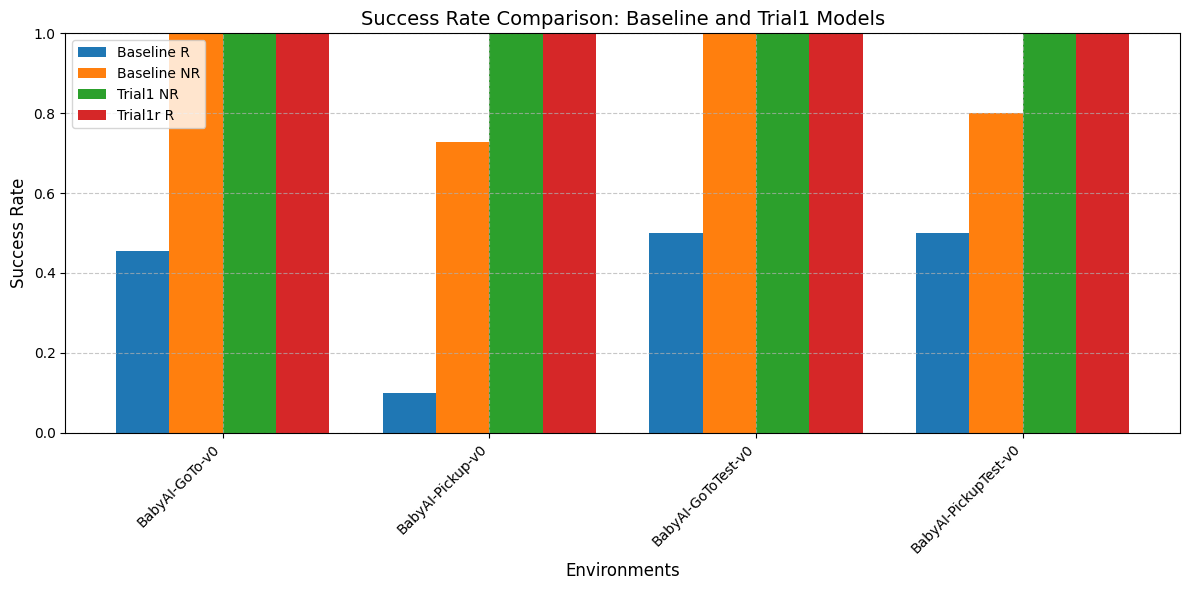

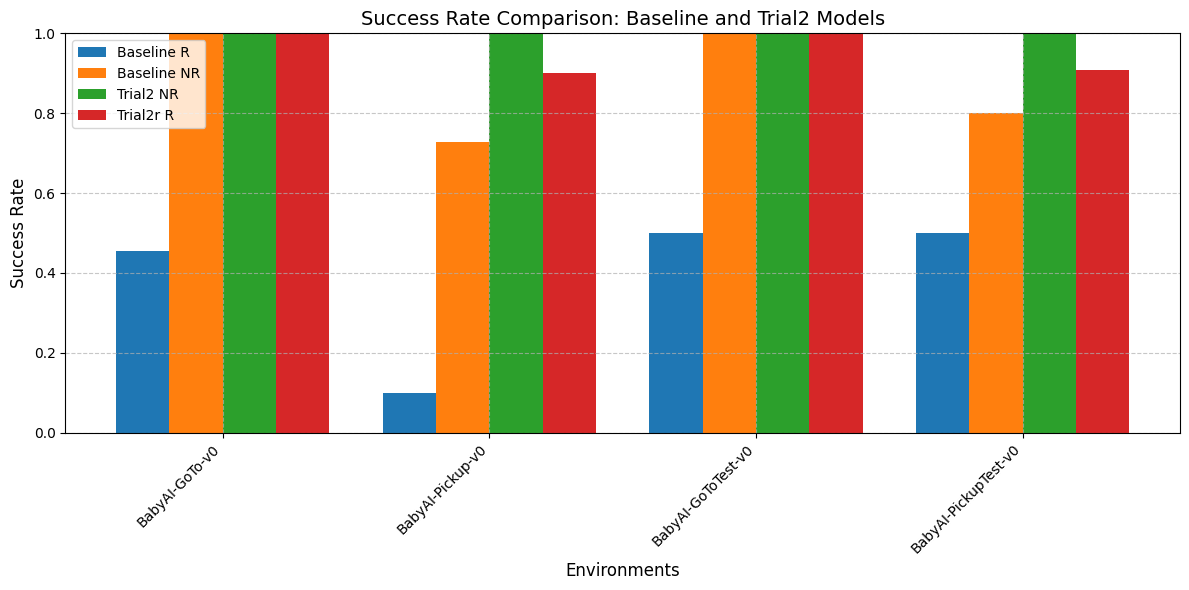

In [10]:
def plot_success_rates(env_ids, model_configs_to_plot, evaluation_results, title):
    """
    Plot bar chart of success rates for specified model configurations across environments.
    
    Args:
        env_ids (list): List of environment IDs to plot.
        model_configs_to_plot (list): List of tuples (model_name, reasoning) to include.
        evaluation_results (dict): Dictionary containing evaluation metrics.
        title (str): Title for the plot.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    n_envs = len(env_ids)
    n_models = len(model_configs_to_plot)
    bar_width = 0.8 / n_models  # Adjust bar width based on number of models
    index = np.arange(n_envs)   # Positions for environment groups
    
    for i, (model_name, reasoning) in enumerate(model_configs_to_plot):
        # Extract success rates for this model configuration
        success_rates = []
        for env in env_ids:
            key = (model_name, env, reasoning)
            if key in evaluation_results:
                success_rates.append(evaluation_results[key]["success_rate"])
            else:
                success_rates.append(0)  # Default to 0 if data is missing
        
        # Plot bars for this model
        label = f"{model_name} {'R' if reasoning else 'NR'}"
        ax.bar(index + i * bar_width, success_rates, bar_width, label=label)
    
    # Customize the plot
    ax.set_xlabel("Environments", fontsize=12)
    ax.set_ylabel("Success Rate", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(index + bar_width * (n_models - 1) / 2)
    ax.set_xticklabels(env_ids, rotation=45, ha='right')
    ax.set_ylim(0, 1)  # Success rate ranges from 0 to 1
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Define all environments to plot
env_ids = seen_env_ids + unseen_env_ids

# First plot: Baseline (R), Baseline (NR), Trial1 (NR), Trial1r (R)
first_plot_models = [
    ("Baseline", True),   # Baseline with reasoning
    ("Baseline", False),  # Baseline without reasoning
    ("Trial1", False),    # Trial1 without reasoning
    ("Trial1r", True)     # Trial1r with reasoning
]
plot_success_rates(
    env_ids=env_ids,
    model_configs_to_plot=first_plot_models,
    evaluation_results=evaluation_results,
    title="Success Rate Comparison: Baseline and Trial1 Models"
)

# Second plot: Baseline (R), Baseline (NR), Trial2 (NR), Trial2r (R)
second_plot_models = [
    ("Baseline", True),   # Baseline with reasoning
    ("Baseline", False),  # Baseline without reasoning
    ("Trial2", False),    # Trial2 without reasoning
    ("Trial2r", True)     # Trial2r with reasoning
]
plot_success_rates(
    env_ids=env_ids,
    model_configs_to_plot=second_plot_models,
    evaluation_results=evaluation_results,
    title="Success Rate Comparison: Baseline and Trial2 Models"
)